In [1]:
from pathlib import Path

import torch
import torchvision
import torchinfo
from torch import nn
from torch.utils.data import DataLoader
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.plot import plot_grids
from torchlake.common.utils.random import generate_normal
from torchlake.image_generation.models.gan import GANDiscriminator, GANGenerator
from torchlake.image_generation.controllers.trainer_gan import GANTrainer
from torchvision import transforms
from tqdm import tqdm

# Setting

In [2]:
IMAGE_SIZE = 32
BATCH_SIZE = 128

In [3]:
artifact_path = Path("../../artifacts/gan")
artifact_path.mkdir(exist_ok=True)

data_path = Path("../../data/fashionMnist")

In [4]:
DEVICE = torch.device("cuda:0")

# Data

In [5]:
preprocess = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        lambda x: x*2-1,
    ]
)

In [6]:
train_data = torchvision.datasets.FashionMNIST(
    root=data_path.as_posix(),
    train=True,
    transform=preprocess,
    download=True,
)

In [7]:
train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
)

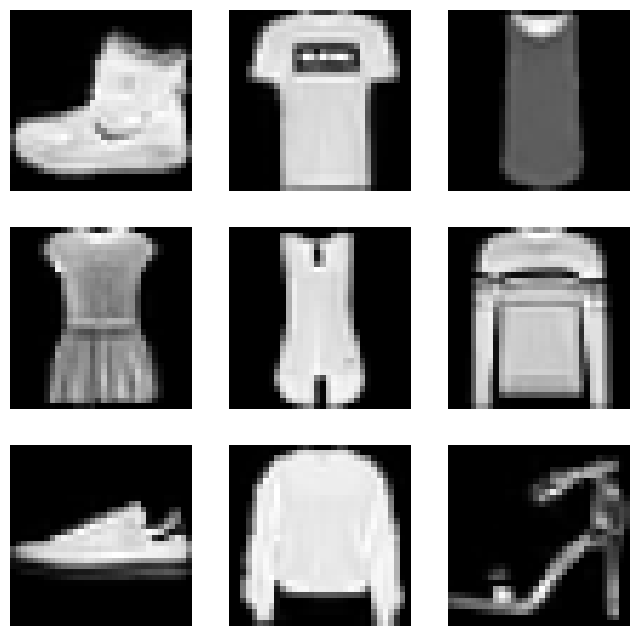

In [8]:
# 資料集繪圖
plot_grids(
    [*img_tensor_to_np(torch.stack([train_data[i][0] for i in range(9)]))],
    num_row=3,
    num_col=3,
    cmap="gray",
)

# model

In [9]:
LATENT_DIM = 128
HIDDEN_DIM = 256

In [10]:
generator = GANGenerator(
    LATENT_DIM,
    HIDDEN_DIM,
    (1, IMAGE_SIZE, IMAGE_SIZE),
).to(DEVICE)
discriminator = GANDiscriminator(
    HIDDEN_DIM,
    (1, IMAGE_SIZE, IMAGE_SIZE),
    dropout_prob=0,
).to(DEVICE)

In [11]:
torchinfo.summary(generator)

Layer (type:depth-idx)                   Param #
GANGenerator                             --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       33,024
│    └─LeakyReLU: 2-2                    --
├─Sequential: 1-2                        --
│    └─Linear: 2-3                       131,584
│    └─LeakyReLU: 2-4                    --
│    └─Linear: 2-5                       525,312
│    └─LeakyReLU: 2-6                    --
├─Sequential: 1-3                        --
│    └─Linear: 2-7                       1,049,600
│    └─Tanh: 2-8                         --
│    └─Unflatten: 2-9                    --
Total params: 1,739,520
Trainable params: 1,739,520
Non-trainable params: 0

In [12]:
torchinfo.summary(discriminator)

Layer (type:depth-idx)                   Param #
GANDiscriminator                         --
├─Sequential: 1-1                        --
│    └─Flatten: 2-1                      --
│    └─Linear: 2-2                       524,800
│    └─LeakyReLU: 2-3                    --
├─Sequential: 1-2                        --
│    └─Linear: 2-4                       131,328
│    └─LeakyReLU: 2-5                    --
├─Sequential: 1-3                        --
│    └─Dropout: 2-6                      --
│    └─Linear: 2-7                       257
Total params: 656,385
Trainable params: 656,385
Non-trainable params: 0

# train

In [13]:
from typing import Any, Generator
from torch import Tensor

def noise_generator(batch_size: int) -> Generator[Tensor, Any, None]:
    yield generate_normal(batch_size, LATENT_DIM).to(DEVICE)

In [14]:
EPOCH = 30

In [15]:
trainer = GANTrainer(EPOCH, DEVICE)

In [16]:
from torchlake.common.controller.recorder import TrainRecorder
recorder = TrainRecorder(total_epoch=EPOCH, num_loss=2)
recorder.increment_data_size(len(train_data))

In [17]:
LR = 1e-4
BETA = (0.5, 0.999)

In [18]:
criterion = nn.BCEWithLogitsLoss(reduction="mean")
optim_G = torch.optim.Adam(generator.parameters(), lr=LR, betas=BETA)
optim_D = torch.optim.Adam(discriminator.parameters(), lr=LR, betas=BETA)

In [19]:
training_losses = trainer.run(
    train_loader,
    noise_generator,
    generator,
    discriminator,
    optim_G,
    optim_D,
    criterion,
    recorder=recorder,
)

Enable AMP: False


100%|██████████| 468/468 [00:22<00:00, 20.94it/s]


epoch 1: D: 0.0032958232892056297 G: 0.008426195603609096


100%|██████████| 468/468 [00:24<00:00, 19.00it/s]


epoch 2: D: 0.005620875500142562 G: 0.025898621616760924


100%|██████████| 468/468 [00:21<00:00, 21.82it/s]


epoch 3: D: 0.008337570043404888 G: 0.04268408520619082


100%|██████████| 468/468 [00:24<00:00, 19.31it/s]


epoch 4: D: 0.01122436574449144 G: 0.060598117103179416


100%|██████████| 468/468 [00:22<00:00, 21.10it/s]


epoch 5: D: 0.01461820108344159 G: 0.07587160743574306


100%|██████████| 468/468 [00:25<00:00, 18.18it/s]


epoch 6: D: 0.01818679042855899 G: 0.0892094404886166


100%|██████████| 468/468 [00:27<00:00, 17.33it/s]


epoch 7: D: 0.021732426832616322 G: 0.10320239993830531


100%|██████████| 468/468 [00:24<00:00, 18.77it/s]


epoch 8: D: 0.02540957717299465 G: 0.1167121775845688


100%|██████████| 468/468 [00:21<00:00, 22.10it/s]


epoch 9: D: 0.029280333697299182 G: 0.1289715196708838


100%|██████████| 468/468 [00:24<00:00, 18.89it/s]


epoch 10: D: 0.0332239371284843 G: 0.1410061851799486


100%|██████████| 468/468 [00:21<00:00, 21.89it/s]


epoch 11: D: 0.03745669078777248 G: 0.1515488610267641


100%|██████████| 468/468 [00:23<00:00, 19.53it/s]


epoch 12: D: 0.04185901773422973 G: 0.16138364257117135


100%|██████████| 468/468 [00:25<00:00, 18.05it/s]


epoch 13: D: 0.046357098142306145 G: 0.17087473236819115


100%|██████████| 468/468 [00:25<00:00, 18.58it/s]


epoch 14: D: 0.0509477394312621 G: 0.17983472147782678


100%|██████████| 468/468 [00:23<00:00, 19.54it/s]


epoch 15: D: 0.055580582667390604 G: 0.18857825827797292


100%|██████████| 468/468 [00:22<00:00, 20.71it/s]


epoch 16: D: 0.060221372115612036 G: 0.19725759699146


100%|██████████| 468/468 [00:21<00:00, 21.97it/s]


epoch 17: D: 0.06490103690922261 G: 0.20576370675265843


100%|██████████| 468/468 [00:22<00:00, 21.21it/s]


epoch 18: D: 0.0696409634391467 G: 0.21406805640657803


100%|██████████| 468/468 [00:22<00:00, 20.62it/s]


epoch 19: D: 0.07439667680958918 G: 0.22224281057417442


100%|██████████| 468/468 [00:25<00:00, 18.55it/s]


epoch 20: D: 0.07915371838013355 G: 0.23035445597668522


100%|██████████| 468/468 [00:21<00:00, 21.72it/s]


epoch 21: D: 0.08396337158183292 G: 0.2383484124620759


100%|██████████| 468/468 [00:22<00:00, 20.74it/s]


epoch 22: D: 0.08881364953716625 G: 0.24617101347943177


100%|██████████| 468/468 [00:22<00:00, 20.40it/s]


epoch 23: D: 0.0937042349656427 G: 0.2538437565058473


100%|██████████| 468/468 [00:23<00:00, 20.08it/s]


epoch 24: D: 0.09863745584090579 G: 0.26126237770617033


100%|██████████| 468/468 [00:22<00:00, 21.05it/s]


epoch 25: D: 0.10359848551154165 G: 0.26854937614897967


100%|██████████| 468/468 [00:22<00:00, 20.75it/s]


epoch 26: D: 0.10856874209543099 G: 0.2758686060448499


100%|██████████| 468/468 [00:25<00:00, 18.69it/s]


epoch 27: D: 0.1135712942411506 G: 0.28315345449646406


100%|██████████| 468/468 [00:21<00:00, 21.28it/s]


epoch 28: D: 0.1185863487402602 G: 0.29036387972931166


100%|██████████| 468/468 [00:22<00:00, 20.97it/s]


epoch 29: D: 0.12358531412680984 G: 0.29752079825302113


100%|██████████| 468/468 [00:20<00:00, 22.99it/s]

epoch 30: D: 0.12861378246744518 G: 0.30463374109268354


# evaluation

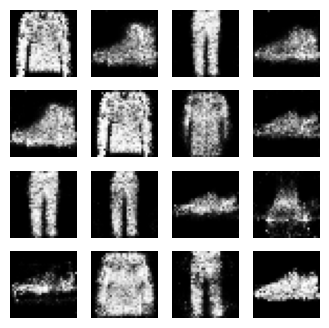

In [35]:
# 合成圖片
generator.eval()
with torch.no_grad():
    noise = generate_normal(16, LATENT_DIM).to(DEVICE)
    gen_img = (generator(noise) + 1) / 2
    
    plot_grids(
        img_tensor_to_np(gen_img),
        num_row=4,
        num_col=4,
        is_gray_scale=True,
        figsize=(4,4),
    )

In [25]:
# 區別是否為真實圖片
generator.eval()
discriminator.eval()
with torch.no_grad():
    hits = 0.0
    for img, _ in tqdm(train_loader):
        img = img.to(DEVICE)
        hits += discriminator(img).sigmoid().gt(0.5).sum().item()

    print(hits / len(train_data))

100%|██████████| 468/468 [00:13<00:00, 34.00it/s]

0.6150666666666667


In [26]:
# 區別是否為合成圖片
generator.eval()
discriminator.eval()
with torch.no_grad():
    hits = 0.0
    for img, label in tqdm(train_loader):
        noise = generate_normal(BATCH_SIZE, LATENT_DIM).to(DEVICE)
        gen_img = generator(noise)
        hits += discriminator(gen_img).sigmoid().gt(0.5).sum().item()
    print(hits / len(train_data))

100%|██████████| 468/468 [00:15<00:00, 30.65it/s]

0.35195


In [27]:
model_path = artifact_path / 'gan.pth'

In [28]:
torch.save(generator.state_dict(), model_path.as_posix())

In [29]:
generator.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>